In [1]:
import os, sys
rmg_path = os.getenv('RMGpy')
if rmg_path and rmg_path not in sys.path:
    sys.path.insert(1,rmg_path)

In [2]:
# Not actually sure which of all these we need...
# it's mostly copied from the importChemkin.py script.
# actually, from some old version that was lying around somewhere :-/
import os
import logging # doesn't work well in a notebook, without some fu
import rmgpy
import rmgpy.rmg
import rmgpy.rmg.input
#from rmgpy.display import display
from IPython.display import display
from rmgpy.chemkin import loadChemkinFile, readSpeciesBlock, readThermoBlock, readReactionsBlock, removeCommentFromLine
from rmgpy.data.thermo import Entry, saveEntry
from rmgpy.data.base import Entry as kinEntry
from rmgpy.data.kinetics.common import saveEntry as kinSaveEntry
from rmgpy.molecule import Molecule
from rmgpy.rmg.model import Species
from rmgpy.reaction import Reaction
from rmgpy.kinetics import Arrhenius
from rmgpy.cantherm.output import prettify
from rmgpy.rmg.main import RMG, initializeLog
from rmgpy.molecule.draw import MoleculeDrawer

#import time
import sys
## Put the RMG-database project at the start of the python path, so we use that importOldDatabase script?
## (is this still needed?)
databaseDirectory = rmgpy.settings['database.directory']
databaseProjectDirectory = os.path.abspath(os.path.join(databaseDirectory, '..'))
sys.path.insert(0, databaseProjectDirectory)

In [3]:
logging.info("Loading RMG database...")
rmg = RMG()
rmg.outputDirectory = '.'
rmg.scratchDirectory = '.'
rmg.databaseDirectory = databaseDirectory
rmg.thermoLibraries = ['primaryThermoLibrary']
rmg.kineticsFamilies = ['H_Abstraction',]
rmg.reactionLibraries = [('KlippensteinH2O2', False),]
rmgpy.rmg.input.rmg = rmg  # put it in this scope so these functions can modify it
#rmg.loadDatabase()  # this seems to hang (forever??) but turns out it's not needed!
logging.info("Loaded database.")

In [4]:
rmg.reactionModel = rmgpy.rmg.model.CoreEdgeReactionModel()
rmg.reactionModel.kineticsEstimator = 'rate rules'
rmg.reactionModel.verboseComments = True
rmg.initialSpecies = []
rmg.reactionSystems = []

def makeOrEmptyDirectory(path):
    """Either create a directory at `path` or delete everything in it if it exists"""
    if os.path.exists(path):
        assert os.path.isdir(path), "Path {0} exists but is not a directory".format(path)
        # empty it out
        for root, dirs, files in os.walk(path, topdown=False):
            for name in files:
                os.remove(os.path.join(root, name))
            for name in dirs:
                os.rmdir(os.path.join(root, name))
    else:
        os.makedirs(path)
        

In [5]:
kineticsLibrary = rmgpy.data.kinetics.KineticsLibrary(
        label="AutoTST-M062X",
        name="AutoTST-M062X",
        solvent=None,
        shortDesc="AutoTST using M062X",
        longDesc="AutoTST calculations using M062X",
        )
def addReactionToKineticsLibrary(reaction):
    """
    Add the reaction (once species are identified) to the reactionLibrary
    """
    entry = kinEntry()
    entry.index = len(kineticsLibrary.entries) + 1
    entry.item = reaction
    entry.label = str(reaction)
    entry.data = reaction.kinetics
    comment = getattr(reaction, 'comment', '')
    if comment:
        entry.longDesc = comment + '.\n'
    else:
        entry.longDesc = ''
    entry.shortDesc = 'AutoTST M062X for {0}'.format(str(reaction))
    kineticsLibrary.entries[entry.index] = entry

def savePyKineticsLibrary(kineticsLibrary):
    "Save an RMG-Py style kinetics library"
    library_path = 'RMG-Py-kinetics-library'
    makeOrEmptyDirectory(library_path)
    kineticsLibrary.checkForDuplicates(markDuplicates=True)
    #kineticsLibrary.convertDuplicatesToMulti()
    kineticsLibrary.save(os.path.join(library_path, 'reactions.py'))
    kineticsLibrary.saveDictionary(os.path.join(library_path, 'dictionary.txt'))

    savedReactions = [kineticsLibrary.entries[key].item 
                      for key in sorted(kineticsLibrary.entries.keys())
                      ]


In [6]:
species_dict = {}

def kinetics(label, kinetics):
    reactants, products = label.split('_')
    reactants = reactants.split('+')
    products = products.split('+')

    reaction = Reaction(reactants=[], products=[], reversible=True)
    
    for in_list, out_list in [(reactants, reaction.reactants), (products, reaction.products)]:
        for i, smiles in enumerate(in_list):
            if smiles not in species_dict:
                species = Species().fromSMILES(smiles)
                species_dict[smiles] = species
                species.label = '{0}({1})'.format(species.toChemkin(), len(species_dict))
            out_list.append(species_dict[smiles])
    
    reaction.kinetics = kinetics
    print repr(reaction)
    display(reaction)
    
    addReactionToKineticsLibrary(reaction)
    

In [7]:
kinetics(
    label = 'C=CCC=C+[O]O_C=C[CH]C=C+OO',
    kinetics = Arrhenius(
        A = (1.46901e-07, 'cm^3/(mol*s)'),
        n = 5.46227,
        Ea = (16.0409, 'kJ/mol'),
        T0 = (1, 'K'),
        Tmin = (303.03, 'K'),
        Tmax = (2500, 'K'),
        comment = 'Fitted to 59 data points; dA = *|/ 2.40766, dn = +|- 0.115316, dEa = +|- 0.634353 kJ/mol',
    ),
)


Reaction(reactants=[Species(label="C5H8(1)", molecule=[Molecule(SMILES="C=CCC=C")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C5H7(3)", molecule=[Molecule(SMILES="C=C[CH]C=C")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(1.46901e-07,'cm^3/(mol*s)'), n=5.46227, Ea=(16.0409,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.40766, dn = +|- 0.115316, dEa = +|- 0.634353 kJ/mol"""))


In [8]:
kineticsLibrary.entries

OrderedDict([(1,
              <Entry index=1 label="C5H8(1) + HO2(2) <=> C5H7(3) + H2O2(4)">)])

In [9]:
savePyKineticsLibrary(kineticsLibrary)

In [10]:
kineticsLibrary.entries.clear()

Next we paste in the results from the previous notebook. Uncomment the first line
```
%run filtered_kinetics.py
```

Reaction(reactants=[Species(label="C5H8(1)", molecule=[Molecule(SMILES="C=CCC=C")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C5H7(3)", molecule=[Molecule(SMILES="C=C[CH]C=C")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(1.46901e-07,'cm^3/(mol*s)'), n=5.46227, Ea=(16.0409,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.40766, dn = +|- 0.115316, dEa = +|- 0.634353 kJ/mol"""))


Reaction(reactants=[Species(label="C2H4O2(5)", molecule=[Molecule(SMILES="COC=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C2H3O2(6)", molecule=[Molecule(SMILES="CO[C]=O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.000827612,'cm^3/(mol*s)'), n=4.50294, Ea=(56.3444,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.33955, dn = +|- 0.0383657, dEa = +|- 0.21105 kJ/mol"""))


Reaction(reactants=[Species(label="C4H8O(7)", molecule=[Molecule(SMILES="CCC=CO")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C4H7O(8)", molecule=[Molecule(SMILES="C[CH]C=CO")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(2.56079e-07,'cm^3/(mol*s)'), n=5.22388, Ea=(11.9207,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.03086, dn = +|- 0.0929786, dEa = +|- 0.511476 kJ/mol"""))


Reaction(reactants=[Species(label="C4H8(9)", molecule=[Molecule(SMILES="CC=CC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C4H7(10)", molecule=[Molecule(SMILES="[CH2]C=CC")])], kinetics=Arrhenius(A=(1.85695e-08,'cm^3/(mol*s)'), n=5.63825, Ea=(24.6184,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.61249, dn = +|- 0.126031, dEa = +|- 0.693299 kJ/mol"""))


Reaction(reactants=[Species(label="C4H8O(11)", molecule=[Molecule(SMILES="C=C(O)CC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C4H7O(12)", molecule=[Molecule(SMILES="C=C(O)[CH]C")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(1.86399e-07,'cm^3/(mol*s)'), n=5.35115, Ea=(20.2957,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.17403, dn = +|- 0.10192, dEa = +|- 0.560659 kJ/mol"""))


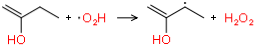

Reaction(reactants=[Species(label="C4H10(13)", molecule=[Molecule(SMILES="CCCC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C4H9(14)", molecule=[Molecule(SMILES="[CH2]CCC")])], kinetics=Arrhenius(A=(0.000948686,'cm^3/(mol*s)'), n=4.38662, Ea=(61.9582,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.26505, dn = +|- 0.0308561, dEa = +|- 0.16974 kJ/mol"""))


Reaction(reactants=[Species(label="C4H8(15)", molecule=[Molecule(SMILES="C=CCC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C4H7(16)", molecule=[Molecule(SMILES="[CH2]CC=C")])], kinetics=Arrhenius(A=(0.000220412,'cm^3/(mol*s)'), n=4.48417, Ea=(61.2327,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.29944, dn = +|- 0.0343761, dEa = +|- 0.189103 kJ/mol"""))


Reaction(reactants=[Species(label="C4H8O(17)", molecule=[Molecule(SMILES="CCCC=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C4H7O(18)", molecule=[Molecule(SMILES="C[CH]CC=O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.000583326,'cm^3/(mol*s)'), n=4.35917, Ea=(44.6771,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.23402, dn = +|- 0.0275975, dEa = +|- 0.151814 kJ/mol"""))


Reaction(reactants=[Species(label="C6H8(19)", molecule=[Molecule(SMILES="C=C1C=CCC1")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C6H7(20)", molecule=[Molecule(SMILES="C=C1[CH]CC=C1")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(1.56034e-10,'cm^3/(mol*s)'), n=6.64499, Ea=(22.1924,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.61527, dn = +|- 0.126171, dEa = +|- 0.694065 kJ/mol"""))


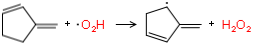

Reaction(reactants=[Species(label="C3H4O(21)", molecule=[Molecule(SMILES="C=CC=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C3H3O(22)", molecule=[Molecule(SMILES="C=C[C]=O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(1.37519e-05,'cm^3/(mol*s)'), n=5.0024, Ea=(30.7116,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.91102, dn = +|- 0.0849968, dEa = +|- 0.467568 kJ/mol"""))


Reaction(reactants=[Species(label="C4H10(23)", molecule=[Molecule(SMILES="CC(C)C")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C4H9(24)", molecule=[Molecule(SMILES="C[C](C)C")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.00381462,'cm^3/(mol*s)'), n=4.38434, Ea=(39.5154,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.2896, dn = +|- 0.0333792, dEa = +|- 0.183619 kJ/mol"""))


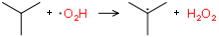

Reaction(reactants=[Species(label="C3H8(25)", molecule=[Molecule(SMILES="CCC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C3H7(26)", molecule=[Molecule(SMILES="C[CH]C")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.000337358,'cm^3/(mol*s)'), n=4.70263, Ea=(46.2109,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.40842, dn = +|- 0.0449463, dEa = +|- 0.24725 kJ/mol"""))


Reaction(reactants=[Species(label="C3H6O2(27)", molecule=[Molecule(SMILES="O=CCCO")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C3H5O2(28)", molecule=[Molecule(SMILES="O=[C]CCO")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.000423229,'cm^3/(mol*s)'), n=4.33217, Ea=(10.9667,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.33794, dn = +|- 0.038208, dEa = +|- 0.210182 kJ/mol"""))


Reaction(reactants=[Species(label="C2H4O2(29)", molecule=[Molecule(SMILES="O=CCO")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C2H3O2(30)", molecule=[Molecule(SMILES="O=[C]CO")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.00108079,'cm^3/(mol*s)'), n=4.22914, Ea=(20.9665,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.27527, dn = +|- 0.0319125, dEa = +|- 0.175551 kJ/mol"""))


Reaction(reactants=[Species(label="C2H4O(31)", molecule=[Molecule(SMILES="CC=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C2H3O(32)", molecule=[Molecule(SMILES="C[C]=O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.000274848,'cm^3/(mol*s)'), n=4.67067, Ea=(21.5744,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.59853, dn = +|- 0.0615635, dEa = +|- 0.338661 kJ/mol"""))


Reaction(reactants=[Species(label="C4H10O(33)", molecule=[Molecule(SMILES="CCC(C)O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C4H9O(34)", molecule=[Molecule(SMILES="C[CH]C(C)O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.000181889,'cm^3/(mol*s)'), n=4.60161, Ea=(54.0961,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.3787, dn = +|- 0.0421467, dEa = +|- 0.231849 kJ/mol"""))


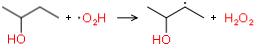

Reaction(reactants=[Species(label="C4H8O(35)", molecule=[Molecule(SMILES="CC(C)C=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C4H7O(36)", molecule=[Molecule(SMILES="CC(C)[C]=O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.000281069,'cm^3/(mol*s)'), n=4.5897, Ea=(15.2284,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.50747, dn = +|- 0.0538655, dEa = +|- 0.296314 kJ/mol"""))


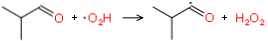

Reaction(reactants=[Species(label="C4H10O(33)", molecule=[Molecule(SMILES="CCC(C)O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C4H9O(37)", molecule=[Molecule(SMILES="[CH2]C(O)CC")])], kinetics=Arrhenius(A=(0.00102796,'cm^3/(mol*s)'), n=4.40852, Ea=(62.869,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.25438, dn = +|- 0.0297452, dEa = +|- 0.163628 kJ/mol"""))


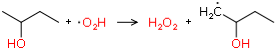

Reaction(reactants=[Species(label="C4H6O(38)", molecule=[Molecule(SMILES="C=C(C)C=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C4H5O(39)", molecule=[Molecule(SMILES="C=C(C)[C]=O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(2.22601e-05,'cm^3/(mol*s)'), n=4.98552, Ea=(32.7154,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.86223, dn = +|- 0.0816026, dEa = +|- 0.448896 kJ/mol"""))


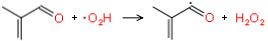

Reaction(reactants=[Species(label="C4H8O(35)", molecule=[Molecule(SMILES="CC(C)C=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C4H7O(40)", molecule=[Molecule(SMILES="[CH2]C(C)C=O")])], kinetics=Arrhenius(A=(0.000383212,'cm^3/(mol*s)'), n=4.55507, Ea=(60.3052,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.33514, dn = +|- 0.0379336, dEa = +|- 0.208673 kJ/mol"""))


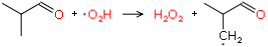

Reaction(reactants=[Species(label="C4H8(41)", molecule=[Molecule(SMILES="C=C(C)C")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C4H7(42)", molecule=[Molecule(SMILES="[CH2]C(=C)C")])], kinetics=Arrhenius(A=(1.05586e-07,'cm^3/(mol*s)'), n=5.54951, Ea=(27.2363,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.32581, dn = +|- 0.110777, dEa = +|- 0.609382 kJ/mol"""))


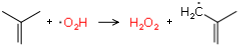

Reaction(reactants=[Species(label="C4H10O(43)", molecule=[Molecule(SMILES="CCCCO")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C4H9O(44)", molecule=[Molecule(SMILES="[CH2]CCCO")])], kinetics=Arrhenius(A=(0.000740853,'cm^3/(mol*s)'), n=4.38311, Ea=(56.8389,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.2143, dn = +|- 0.0254829, dEa = +|- 0.140181 kJ/mol"""))


Reaction(reactants=[Species(label="C4H10(13)", molecule=[Molecule(SMILES="CCCC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C4H9(45)", molecule=[Molecule(SMILES="C[CH]CC")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.00210652,'cm^3/(mol*s)'), n=4.45303, Ea=(49.819,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.32839, dn = +|- 0.0372684, dEa = +|- 0.205013 kJ/mol"""))


Reaction(reactants=[Species(label="C4H8O(46)", molecule=[Molecule(SMILES="CC=C(C)O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C4H7O(47)", molecule=[Molecule(SMILES="[CH2]C(O)=CC")])], kinetics=Arrhenius(A=(3.05514e-08,'cm^3/(mol*s)'), n=5.43438, Ea=(20.7556,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.21916, dn = +|- 0.104616, dEa = +|- 0.575492 kJ/mol"""))


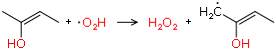

Reaction(reactants=[Species(label="C3H6(48)", molecule=[Molecule(SMILES="C=CC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C3H5(49)", molecule=[Molecule(SMILES="[CH2]C=C")])], kinetics=Arrhenius(A=(1.23038e-10,'cm^3/(mol*s)'), n=6.60553, Ea=(19.4098,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.5386, dn = +|- 0.122266, dEa = +|- 0.672585 kJ/mol"""))


Reaction(reactants=[Species(label="C2H6O(50)", molecule=[Molecule(SMILES="CCO")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C2H5O(51)", molecule=[Molecule(SMILES="[CH2]CO")])], kinetics=Arrhenius(A=(0.000409287,'cm^3/(mol*s)'), n=4.70424, Ea=(67.0893,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.42706, dn = +|- 0.0466716, dEa = +|- 0.256741 kJ/mol"""))


Reaction(reactants=[Species(label="C4H8O(17)", molecule=[Molecule(SMILES="CCCC=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C4H7O(52)", molecule=[Molecule(SMILES="[CH2]CCC=O")])], kinetics=Arrhenius(A=(0.0059468,'cm^3/(mol*s)'), n=4.14413, Ea=(57.888,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.13258, dn = +|- 0.0163398, dEa = +|- 0.0898853 kJ/mol"""))


Reaction(reactants=[Species(label="C4H8(15)", molecule=[Molecule(SMILES="C=CCC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C4H7(53)", molecule=[Molecule(SMILES="C=C[CH]C")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(4.20615e-08,'cm^3/(mol*s)'), n=5.62053, Ea=(19.7262,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.56265, dn = +|- 0.123503, dEa = +|- 0.679391 kJ/mol"""))


Reaction(reactants=[Species(label="C6H8(54)", molecule=[Molecule(SMILES="C=C1CC=CC1")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C6H7(55)", molecule=[Molecule(SMILES="C=C1[CH]C=CC1")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(2.01875e-07,'cm^3/(mol*s)'), n=5.07549, Ea=(10.2176,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.93084, dn = +|- 0.0863504, dEa = +|- 0.475014 kJ/mol"""))


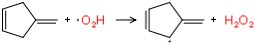

Reaction(reactants=[Species(label="C4H10O(56)", molecule=[Molecule(SMILES="CC(C)(C)O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C4H9O(57)", molecule=[Molecule(SMILES="[CH2]C(C)(C)O")])], kinetics=Arrhenius(A=(0.0142764,'cm^3/(mol*s)'), n=4.09233, Ea=(66.0716,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.12286, dn = +|- 0.015208, dEa = +|- 0.0836592 kJ/mol"""))


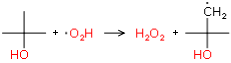

Reaction(reactants=[Species(label="C6H8(58)", molecule=[Molecule(SMILES="C1C=CCCC=1")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C6H7(59)", molecule=[Molecule(SMILES="[CH]1C=CC=CC1")])], kinetics=Arrhenius(A=(2.81635e-06,'cm^3/(mol*s)'), n=5.07119, Ea=(13.2806,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.95305, dn = +|- 0.0878515, dEa = +|- 0.483272 kJ/mol"""))


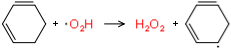

Reaction(reactants=[Species(label="C2H6O(50)", molecule=[Molecule(SMILES="CCO")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C2H5O(60)", molecule=[Molecule(SMILES="C[CH]O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.000564314,'cm^3/(mol*s)'), n=4.34123, Ea=(31.9151,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.28242, dn = +|- 0.0326461, dEa = +|- 0.179587 kJ/mol"""))


Reaction(reactants=[Species(label="C3H8(25)", molecule=[Molecule(SMILES="CCC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C3H7(61)", molecule=[Molecule(SMILES="[CH2]CC")])], kinetics=Arrhenius(A=(0.000510827,'cm^3/(mol*s)'), n=4.59277, Ea=(58.4923,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.32453, dn = +|- 0.0368865, dEa = +|- 0.202913 kJ/mol"""))


Reaction(reactants=[Species(label="C4H10O(43)", molecule=[Molecule(SMILES="CCCCO")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C4H9O(62)", molecule=[Molecule(SMILES="CCC[CH]O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.000166121,'cm^3/(mol*s)'), n=4.53539, Ea=(32.6901,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.36841, dn = +|- 0.0411636, dEa = +|- 0.226441 kJ/mol"""))


Reaction(reactants=[Species(label="C4H8O(17)", molecule=[Molecule(SMILES="CCCC=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C4H7O(63)", molecule=[Molecule(SMILES="CCC[C]=O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(7.91164e-05,'cm^3/(mol*s)'), n=4.59616, Ea=(16.6055,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.52125, dn = +|- 0.0550603, dEa = +|- 0.302887 kJ/mol"""))


Reaction(reactants=[Species(label="C3H6O(64)", molecule=[Molecule(SMILES="CC(C)=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C3H5O(65)", molecule=[Molecule(SMILES="[CH2]C(C)=O")])], kinetics=Arrhenius(A=(3.89078e-06,'cm^3/(mol*s)'), n=4.90542, Ea=(44.584,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.61705, dn = +|- 0.0630746, dEa = +|- 0.346973 kJ/mol"""))


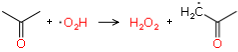

Reaction(reactants=[Species(label="C2H6O(66)", molecule=[Molecule(SMILES="COC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C2H5O(67)", molecule=[Molecule(SMILES="[CH2]OC")])], kinetics=Arrhenius(A=(0.00107875,'cm^3/(mol*s)'), n=4.37156, Ea=(38.6209,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.26938, dn = +|- 0.0313052, dEa = +|- 0.17221 kJ/mol"""))


Reaction(reactants=[Species(label="C4H8O(68)", molecule=[Molecule(SMILES="CCC(C)=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C4H7O(69)", molecule=[Molecule(SMILES="C[CH]C(C)=O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(1.10146e-06,'cm^3/(mol*s)'), n=5.12066, Ea=(31.0702,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.82321, dn = +|- 0.0788229, dEa = +|- 0.433605 kJ/mol"""))


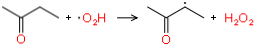

Reaction(reactants=[Species(label="C2H4O(70)", molecule=[Molecule(SMILES="C1CO1")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C2H3O(71)", molecule=[Molecule(SMILES="[CH]1CO1")])], kinetics=Arrhenius(A=(0.102149,'cm^3/(mol*s)'), n=3.87668, Ea=(70.1773,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.07587, dn = +|- 0.00959792, dEa = +|- 0.0527982 kJ/mol"""))


Reaction(reactants=[Species(label="C5H6(72)", molecule=[Molecule(SMILES="C1C=CCC=1")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C5H5(73)", molecule=[Molecule(SMILES="[CH]1C=CC=C1")])], kinetics=Arrhenius(A=(2.75415e-08,'cm^3/(mol*s)'), n=5.57639, Ea=(16.934,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.51401, dn = +|- 0.120988, dEa = +|- 0.665557 kJ/mol"""))


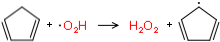

Reaction(reactants=[Species(label="C4H8O(17)", molecule=[Molecule(SMILES="CCCC=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C4H7O(74)", molecule=[Molecule(SMILES="CC[CH]C=O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(1.70895e-08,'cm^3/(mol*s)'), n=5.53146, Ea=(26.0936,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.42086, dn = +|- 0.116033, dEa = +|- 0.638298 kJ/mol"""))


Reaction(reactants=[Species(label="C2H6(75)", molecule=[Molecule(SMILES="CC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C2H5(76)", molecule=[Molecule(SMILES="C[CH2]")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.00107611,'cm^3/(mol*s)'), n=4.64503, Ea=(58.9259,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.37643, dn = +|- 0.0419307, dEa = +|- 0.230661 kJ/mol"""))


Reaction(reactants=[Species(label="C2H4O2(5)", molecule=[Molecule(SMILES="COC=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C2H3O2(77)", molecule=[Molecule(SMILES="[CH2]OC=O")])], kinetics=Arrhenius(A=(0.000104186,'cm^3/(mol*s)'), n=4.50983, Ea=(53.7734,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.315, dn = +|- 0.0359384, dEa = +|- 0.197697 kJ/mol"""))


Reaction(reactants=[Species(label="C4H10O(33)", molecule=[Molecule(SMILES="CCC(C)O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C4H9O(78)", molecule=[Molecule(SMILES="[CH2]CC(C)O")])], kinetics=Arrhenius(A=(9.523e-05,'cm^3/(mol*s)'), n=4.57604, Ea=(61.4648,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.37128, dn = +|- 0.0414389, dEa = +|- 0.227956 kJ/mol"""))


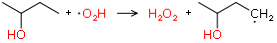

Reaction(reactants=[Species(label="C4H6O(79)", molecule=[Molecule(SMILES="CC=CC=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C4H5O(80)", molecule=[Molecule(SMILES="CC=C[C]=O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(1.63673e-05,'cm^3/(mol*s)'), n=4.91506, Ea=(23.471,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.76652, dn = +|- 0.0746773, dEa = +|- 0.4108 kJ/mol"""))


Reaction(reactants=[Species(label="C6H8(19)", molecule=[Molecule(SMILES="C=C1C=CCC1")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C6H7(81)", molecule=[Molecule(SMILES="C=C1C=C[CH]C1")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(3.96701e-10,'cm^3/(mol*s)'), n=6.4638, Ea=(13.0827,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.31164, dn = +|- 0.109974, dEa = +|- 0.604968 kJ/mol"""))


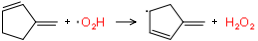

Reaction(reactants=[Species(label="C4H8O(68)", molecule=[Molecule(SMILES="CCC(C)=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C4H7O(82)", molecule=[Molecule(SMILES="[CH2]C(=O)CC")])], kinetics=Arrhenius(A=(8.05561e-07,'cm^3/(mol*s)'), n=5.00571, Ea=(50.7329,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.73253, dn = +|- 0.0721277, dEa = +|- 0.396774 kJ/mol"""))


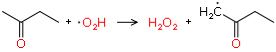

Reaction(reactants=[Species(label="C3H6O(83)", molecule=[Molecule(SMILES="CCC=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C3H5O(84)", molecule=[Molecule(SMILES="CC[C]=O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.000293965,'cm^3/(mol*s)'), n=4.67279, Ea=(13.2914,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.50013, dn = +|- 0.0532249, dEa = +|- 0.29279 kJ/mol"""))


Reaction(reactants=[Species(label="C4H10(23)", molecule=[Molecule(SMILES="CC(C)C")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C4H9(85)", molecule=[Molecule(SMILES="[CH2]C(C)C")])], kinetics=Arrhenius(A=(0.000832921,'cm^3/(mol*s)'), n=4.41042, Ea=(60.4783,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.25863, dn = +|- 0.0301881, dEa = +|- 0.166065 kJ/mol"""))


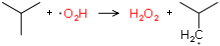

Reaction(reactants=[Species(label="C4H10O(86)", molecule=[Molecule(SMILES="CC(C)CO")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C4H9O(87)", molecule=[Molecule(SMILES="[CH2]C(C)CO")])], kinetics=Arrhenius(A=(0.001262,'cm^3/(mol*s)'), n=4.35918, Ea=(59.5366,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.22938, dn = +|- 0.0271023, dEa = +|- 0.14909 kJ/mol"""))


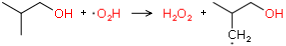

Reaction(reactants=[Species(label="CH4O(88)", molecule=[Molecule(SMILES="CO")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="CH3O(89)", molecule=[Molecule(SMILES="[CH2]O")])], kinetics=Arrhenius(A=(8.64717e-05,'cm^3/(mol*s)'), n=4.75283, Ea=(41.0765,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.49505, dn = +|- 0.0527799, dEa = +|- 0.290342 kJ/mol"""))


Reaction(reactants=[Species(label="C4H10O(43)", molecule=[Molecule(SMILES="CCCCO")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C4H9O(90)", molecule=[Molecule(SMILES="C[CH]CCO")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.000375686,'cm^3/(mol*s)'), n=4.61727, Ea=(47.4469,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.3677, dn = +|- 0.0410955, dEa = +|- 0.226066 kJ/mol"""))


Reaction(reactants=[Species(label="C4H10O(86)", molecule=[Molecule(SMILES="CC(C)CO")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C4H9O(91)", molecule=[Molecule(SMILES="CC(C)[CH]O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.000391488,'cm^3/(mol*s)'), n=4.50526, Ea=(36.07,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.36394, dn = +|- 0.0407347, dEa = +|- 0.224082 kJ/mol"""))


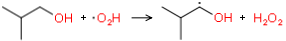

Reaction(reactants=[Species(label="C4H8O(68)", molecule=[Molecule(SMILES="CCC(C)=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C4H7O(92)", molecule=[Molecule(SMILES="[CH2]CC(C)=O")])], kinetics=Arrhenius(A=(0.000631728,'cm^3/(mol*s)'), n=4.64055, Ea=(66.8149,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.40113, dn = +|- 0.0442652, dEa = +|- 0.243503 kJ/mol"""))


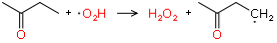

Reaction(reactants=[Species(label="C5H8(93)", molecule=[Molecule(SMILES="C=CC=CC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C5H7(94)", molecule=[Molecule(SMILES="[CH2]C=CC=C")])], kinetics=Arrhenius(A=(4.0144e-10,'cm^3/(mol*s)'), n=6.30656, Ea=(24.2759,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 3.91317, dn = +|- 0.179058, dEa = +|- 0.985 kJ/mol"""))


Reaction(reactants=[Species(label="CH2O(95)", molecule=[Molecule(SMILES="C=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="CHO(96)", molecule=[Molecule(SMILES="[CH]=O")])], kinetics=Arrhenius(A=(4.23547e-06,'cm^3/(mol*s)'), n=5.20393, Ea=(21.3195,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.04626, dn = +|- 0.0939706, dEa = +|- 0.516933 kJ/mol"""))


Reaction(reactants=[Species(label="C4H10O(43)", molecule=[Molecule(SMILES="CCCCO")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C4H9O(97)", molecule=[Molecule(SMILES="CC[CH]CO")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.0157366,'cm^3/(mol*s)'), n=3.87722, Ea=(45.4966,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.06497, dn = +|- 0.00826126, dEa = +|- 0.0454452 kJ/mol"""))


Reaction(reactants=[Species(label="C5H6O(98)", molecule=[Molecule(SMILES="OC1C=CC=C1")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C5H5O(99)", molecule=[Molecule(SMILES="O[C]1C=CC=C1")])], kinetics=Arrhenius(A=(3.12783e-05,'cm^3/(mol*s)'), n=4.72352, Ea=(7.13709,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.59015, dn = +|- 0.0608733, dEa = +|- 0.334864 kJ/mol"""))


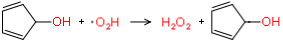

Reaction(reactants=[Species(label="C5H6O(100)", molecule=[Molecule(SMILES="C1C=COCC=1")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C5H5O(101)", molecule=[Molecule(SMILES="[CH]1C=CC=CO1")])], kinetics=Arrhenius(A=(0.000170319,'cm^3/(mol*s)'), n=4.61962, Ea=(12.6354,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.60068, dn = +|- 0.0617396, dEa = +|- 0.33963 kJ/mol"""))


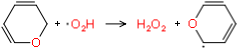

Reaction(reactants=[Species(label="C6H10O(102)", molecule=[Molecule(SMILES="C=C(C)C(=O)CC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C6H9O(103)", molecule=[Molecule(SMILES="[CH2]C(=C)C(=O)CC")])], kinetics=Arrhenius(A=(2.55372e-07,'cm^3/(mol*s)'), n=5.11729, Ea=(14.3227,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.78771, dn = +|- 0.0762425, dEa = +|- 0.41941 kJ/mol"""))


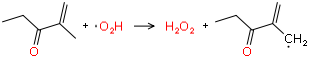

Reaction(reactants=[Species(label="C5H10(104)", molecule=[Molecule(SMILES="C=CCCC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C5H9(105)", molecule=[Molecule(SMILES="C=C[CH]CC")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(2.82936e-08,'cm^3/(mol*s)'), n=5.57639, Ea=(21.9866,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.59144, dn = +|- 0.12497, dEa = +|- 0.687458 kJ/mol"""))


Reaction(reactants=[Species(label="C6H10O(106)", molecule=[Molecule(SMILES="C=CC(=O)C(C)C")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C6H9O(107)", molecule=[Molecule(SMILES="[CH2]C(C)C(=O)C=C")])], kinetics=Arrhenius(A=(0.0114732,'cm^3/(mol*s)'), n=3.89426, Ea=(57.6883,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.07028, dn = +|- 0.00891434, dEa = +|- 0.0490378 kJ/mol"""))


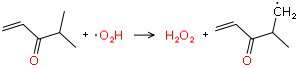

Reaction(reactants=[Species(label="C3H4O3(108)", molecule=[Molecule(SMILES="O=CCOC=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C3H3O3(109)", molecule=[Molecule(SMILES="O=C[CH]OC=O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(3.46381e-10,'cm^3/(mol*s)'), n=6.0746, Ea=(20.7976,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 3.18244, dn = +|- 0.151931, dEa = +|- 0.835772 kJ/mol"""))


Reaction(reactants=[Species(label="C5H10O(110)", molecule=[Molecule(SMILES="C1CCOCC1")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C5H9O(111)", molecule=[Molecule(SMILES="[CH]1CCOCC1")])], kinetics=Arrhenius(A=(0.000361794,'cm^3/(mol*s)'), n=4.67589, Ea=(51.9521,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.43309, dn = +|- 0.047225, dEa = +|- 0.259785 kJ/mol"""))


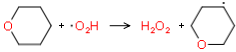

Reaction(reactants=[Species(label="C4H6O(112)", molecule=[Molecule(SMILES="C=CCC=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C4H5O(113)", molecule=[Molecule(SMILES="C=CC[C]=O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(2.26288e-05,'cm^3/(mol*s)'), n=4.75547, Ea=(17.2215,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.6202, dn = +|- 0.0633302, dEa = +|- 0.34838 kJ/mol"""))


Reaction(reactants=[Species(label="C7H8(114)", molecule=[Molecule(SMILES="C=C1C=CC=CC1")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C7H7(115)", molecule=[Molecule(SMILES="C=C1[CH]C=CC=C1")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(3.55735e-05,'cm^3/(mol*s)'), n=5.09377, Ea=(-2.60251,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.15687, dn = +|- 0.0191237, dEa = +|- 0.1052 kJ/mol"""))


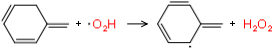

Reaction(reactants=[Species(label="C5H8O(116)", molecule=[Molecule(SMILES="C=CC(=O)CC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C5H7O(117)", molecule=[Molecule(SMILES="[CH2]CC(=O)C=C")])], kinetics=Arrhenius(A=(0.00802742,'cm^3/(mol*s)'), n=3.97344, Ea=(51.4742,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.08142, dn = +|- 0.010273, dEa = +|- 0.056512 kJ/mol"""))


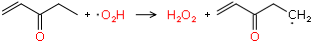

Reaction(reactants=[Species(label="C4H6O2(118)", molecule=[Molecule(SMILES="C=CC(=O)OC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C4H5O2(119)", molecule=[Molecule(SMILES="[CH]=CC(=O)OC")])], kinetics=Arrhenius(A=(0.228563,'cm^3/(mol*s)'), n=3.85957, Ea=(100.481,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.06853, dn = +|- 0.00869905, dEa = +|- 0.0478535 kJ/mol"""))


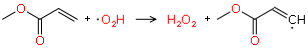

Reaction(reactants=[Species(label="CH2O2(120)", molecule=[Molecule(SMILES="O=CO")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="CHO2(121)", molecule=[Molecule(SMILES="[O]C=O")])], kinetics=Arrhenius(A=(1.16738,'cm^3/(mol*s)'), n=3.6382, Ea=(96.8331,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.02165, dn = +|- 0.00281125, dEa = +|- 0.0154647 kJ/mol"""))


Reaction(reactants=[Species(label="C6H12(122)", molecule=[Molecule(SMILES="C=CCCCC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C6H11(123)", molecule=[Molecule(SMILES="C=CC[CH]CC")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.00126402,'cm^3/(mol*s)'), n=4.35832, Ea=(49.4485,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.26192, dn = +|- 0.0305317, dEa = +|- 0.167955 kJ/mol"""))


Reaction(reactants=[Species(label="C5H12(124)", molecule=[Molecule(SMILES="CCC(C)C")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C5H11(125)", molecule=[Molecule(SMILES="CC[C](C)C")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.00483184,'cm^3/(mol*s)'), n=4.25851, Ea=(39.4875,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.22068, dn = +|- 0.0261707, dEa = +|- 0.143965 kJ/mol"""))


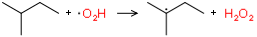

Reaction(reactants=[Species(label="C3H8O(126)", molecule=[Molecule(SMILES="CCCO")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C3H7O(127)", molecule=[Molecule(SMILES="[CH2]CCO")])], kinetics=Arrhenius(A=(0.000461344,'cm^3/(mol*s)'), n=4.49371, Ea=(61.8638,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.31972, dn = +|- 0.0364087, dEa = +|- 0.200284 kJ/mol"""))


Reaction(reactants=[Species(label="C5H8O2(128)", molecule=[Molecule(SMILES="CC=CC(=O)OC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C5H7O2(129)", molecule=[Molecule(SMILES="[CH2]C=CC(=O)OC")])], kinetics=Arrhenius(A=(6.96075e-09,'cm^3/(mol*s)'), n=5.81809, Ea=(24.2053,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.9056, dn = +|- 0.139987, dEa = +|- 0.770069 kJ/mol"""))


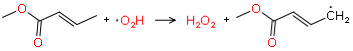

Reaction(reactants=[Species(label="C3H8O(130)", molecule=[Molecule(SMILES="CC(C)O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C3H7O(131)", molecule=[Molecule(SMILES="[CH2]C(C)O")])], kinetics=Arrhenius(A=(0.000348513,'cm^3/(mol*s)'), n=4.53302, Ea=(66.5864,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.32675, dn = +|- 0.0371059, dEa = +|- 0.20412 kJ/mol"""))


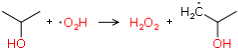

Reaction(reactants=[Species(label="C5H10O(132)", molecule=[Molecule(SMILES="CCC(=O)CC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C5H9O(133)", molecule=[Molecule(SMILES="[CH2]CC(=O)CC")])], kinetics=Arrhenius(A=(0.0145262,'cm^3/(mol*s)'), n=3.80511, Ea=(57.7743,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.05418, dn = +|- 0.00692463, dEa = +|- 0.0380924 kJ/mol"""))


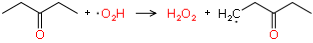

Reaction(reactants=[Species(label="C3H4O3(134)", molecule=[Molecule(SMILES="COC(=O)C=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C3H3O3(135)", molecule=[Molecule(SMILES="COC(=O)[C]=O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(1.87971e-07,'cm^3/(mol*s)'), n=5.45116, Ea=(21.2124,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.11512, dn = +|- 0.0983145, dEa = +|- 0.540828 kJ/mol"""))


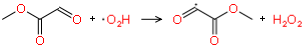

Reaction(reactants=[Species(label="C5H8O(136)", molecule=[Molecule(SMILES="C=CCCC=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C5H7O(137)", molecule=[Molecule(SMILES="C=CCC[C]=O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.000219287,'cm^3/(mol*s)'), n=4.66965, Ea=(18.4724,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.58821, dn = +|- 0.060713, dEa = +|- 0.333982 kJ/mol"""))


Reaction(reactants=[Species(label="C7H12(138)", molecule=[Molecule(SMILES="C=CCCC(=C)C")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C7H11(139)", molecule=[Molecule(SMILES="[CH2]C(=C)CCC=C")])], kinetics=Arrhenius(A=(3.24649e-08,'cm^3/(mol*s)'), n=5.60943, Ea=(27.1191,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.49933, dn = +|- 0.12022, dEa = +|- 0.661328 kJ/mol"""))


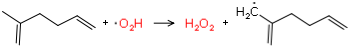

Reaction(reactants=[Species(label="C7H8(140)", molecule=[Molecule(SMILES="C=C1C=CCC=C1")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C7H7(141)", molecule=[Molecule(SMILES="C=C1C=C[CH]C=C1")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(5.68621e-05,'cm^3/(mol*s)'), n=4.6047, Ea=(3.1184,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.45361, dn = +|- 0.049091, dEa = +|- 0.27005 kJ/mol"""))


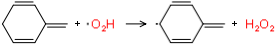

Reaction(reactants=[Species(label="C4H6O(112)", molecule=[Molecule(SMILES="C=CCC=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C4H5O(142)", molecule=[Molecule(SMILES="C=C[CH]C=O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(8.06564e-08,'cm^3/(mol*s)'), n=5.3915, Ea=(12.0237,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.24336, dn = +|- 0.10604, dEa = +|- 0.583324 kJ/mol"""))


Reaction(reactants=[Species(label="C5H10O(143)", molecule=[Molecule(SMILES="CCCCC=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C5H9O(144)", molecule=[Molecule(SMILES="CC[CH]CC=O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.000465233,'cm^3/(mol*s)'), n=4.45855, Ea=(47.2106,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.2802, dn = +|- 0.0324186, dEa = +|- 0.178335 kJ/mol"""))


Reaction(reactants=[Species(label="C5H8O(145)", molecule=[Molecule(SMILES="C1=COCCC1")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C5H7O(146)", molecule=[Molecule(SMILES="[CH]1C=COCC1")])], kinetics=Arrhenius(A=(2.87713e-08,'cm^3/(mol*s)'), n=5.75789, Ea=(26.0319,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.96685, dn = +|- 0.142725, dEa = +|- 0.785129 kJ/mol"""))


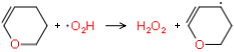

Reaction(reactants=[Species(label="C3H8O(126)", molecule=[Molecule(SMILES="CCCO")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C3H7O(147)", molecule=[Molecule(SMILES="CC[CH]O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.000358264,'cm^3/(mol*s)'), n=4.40545, Ea=(36.0846,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.34315, dn = +|- 0.0387185, dEa = +|- 0.21299 kJ/mol"""))


Reaction(reactants=[Species(label="CH2O2(120)", molecule=[Molecule(SMILES="O=CO")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="CHO2(148)", molecule=[Molecule(SMILES="O=[C]O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.00509617,'cm^3/(mol*s)'), n=4.05194, Ea=(31.2032,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.1489, dn = +|- 0.0182168, dEa = +|- 0.100211 kJ/mol"""))


Reaction(reactants=[Species(label="C5H10(149)", molecule=[Molecule(SMILES="CC=CCC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C5H9(150)", molecule=[Molecule(SMILES="C[CH]C=CC")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(1.28196e-07,'cm^3/(mol*s)'), n=5.39686, Ea=(20.0928,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.32117, dn = +|- 0.110514, dEa = +|- 0.60794 kJ/mol"""))


Reaction(reactants=[Species(label="C7H14(151)", molecule=[Molecule(SMILES="CC=CCCCC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C7H13(152)", molecule=[Molecule(SMILES="[CH2]C=CCCCC")])], kinetics=Arrhenius(A=(1.21402e-09,'cm^3/(mol*s)'), n=5.66517, Ea=(24.7896,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.7249, dn = +|- 0.13156, dEa = +|- 0.723714 kJ/mol"""))


Reaction(reactants=[Species(label="C7H14(153)", molecule=[Molecule(SMILES="CC1CCCCC1")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C7H13(154)", molecule=[Molecule(SMILES="CC1CC[CH]CC1")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.000120537,'cm^3/(mol*s)'), n=4.66555, Ea=(52.379,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.46815, dn = +|- 0.0503972, dEa = +|- 0.277235 kJ/mol"""))


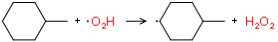

Reaction(reactants=[Species(label="C7H14(153)", molecule=[Molecule(SMILES="CC1CCCCC1")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C7H13(155)", molecule=[Molecule(SMILES="[CH2]C1CCCCC1")])], kinetics=Arrhenius(A=(5.60398e-05,'cm^3/(mol*s)'), n=4.74358, Ea=(63.8521,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.49211, dn = +|- 0.0525215, dEa = +|- 0.288921 kJ/mol"""))


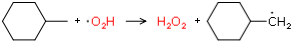

Reaction(reactants=[Species(label="C3H4O3(108)", molecule=[Molecule(SMILES="O=CCOC=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C3H3O3(156)", molecule=[Molecule(SMILES="O=[C]COC=O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.00062496,'cm^3/(mol*s)'), n=4.16015, Ea=(10.4933,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.17726, dn = +|- 0.0214174, dEa = +|- 0.117817 kJ/mol"""))


Reaction(reactants=[Species(label="C6H12(122)", molecule=[Molecule(SMILES="C=CCCCC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C6H11(157)", molecule=[Molecule(SMILES="C=CCC[CH]C")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.00100139,'cm^3/(mol*s)'), n=4.46378, Ea=(48.8841,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.31767, dn = +|- 0.0362051, dEa = +|- 0.199165 kJ/mol"""))


Reaction(reactants=[Species(label="C7H14(153)", molecule=[Molecule(SMILES="CC1CCCCC1")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C7H13(158)", molecule=[Molecule(SMILES="CC1[CH]CCCC1")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.00136098,'cm^3/(mol*s)'), n=4.39776, Ea=(50.8253,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.28772, dn = +|- 0.0331873, dEa = +|- 0.182563 kJ/mol"""))


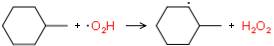

Reaction(reactants=[Species(label="C6H12O(159)", molecule=[Molecule(SMILES="CCCC(=O)CC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C6H11O(160)", molecule=[Molecule(SMILES="[CH2]CCC(=O)CC")])], kinetics=Arrhenius(A=(0.000435069,'cm^3/(mol*s)'), n=4.40483, Ea=(57.9043,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.22723, dn = +|- 0.0268733, dEa = +|- 0.14783 kJ/mol"""))


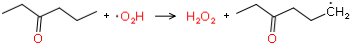

Reaction(reactants=[Species(label="C3H8O(130)", molecule=[Molecule(SMILES="CC(C)O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C3H7O(161)", molecule=[Molecule(SMILES="C[C](C)O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.00161843,'cm^3/(mol*s)'), n=4.41608, Ea=(31.2187,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.34896, dn = +|- 0.0392853, dEa = +|- 0.216109 kJ/mol"""))


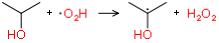

Reaction(reactants=[Species(label="C7H10(162)", molecule=[Molecule(SMILES="CC1=CC=CCC1")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C7H9(163)", molecule=[Molecule(SMILES="[CH2]C1=CC=CCC1")])], kinetics=Arrhenius(A=(1.50381e-08,'cm^3/(mol*s)'), n=5.67296, Ea=(15.8252,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.65616, dn = +|- 0.128207, dEa = +|- 0.705266 kJ/mol"""))


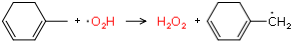

Reaction(reactants=[Species(label="C6H10O(102)", molecule=[Molecule(SMILES="C=C(C)C(=O)CC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C6H9O(164)", molecule=[Molecule(SMILES="[CH2]CC(=O)C(=C)C")])], kinetics=Arrhenius(A=(0.0221951,'cm^3/(mol*s)'), n=3.87815, Ea=(52.5291,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.06472, dn = +|- 0.00823067, dEa = +|- 0.0452769 kJ/mol"""))


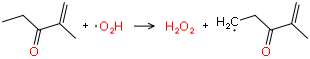

Reaction(reactants=[Species(label="C3H2O3(165)", molecule=[Molecule(SMILES="O=C=COC=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C3HO3(166)", molecule=[Molecule(SMILES="O=[C]OC=C=O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.00288574,'cm^3/(mol*s)'), n=4.41263, Ea=(60.7819,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.29956, dn = +|- 0.0343888, dEa = +|- 0.189173 kJ/mol"""))


Reaction(reactants=[Species(label="C7H14(167)", molecule=[Molecule(SMILES="CCC=CCCC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C7H13(168)", molecule=[Molecule(SMILES="C[CH]C=CCCC")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(3.72086e-08,'cm^3/(mol*s)'), n=5.32048, Ea=(18.5576,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.29457, dn = +|- 0.109002, dEa = +|- 0.599619 kJ/mol"""))


Reaction(reactants=[Species(label="C6H12O(159)", molecule=[Molecule(SMILES="CCCC(=O)CC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C6H11O(169)", molecule=[Molecule(SMILES="CC[CH]C(=O)CC")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(4.02307e-09,'cm^3/(mol*s)'), n=5.71222, Ea=(30.2333,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.53715, dn = +|- 0.122191, dEa = +|- 0.672172 kJ/mol"""))


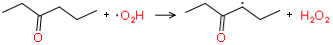

Reaction(reactants=[Species(label="C5H6(170)", molecule=[Molecule(SMILES="C1C=CCC=1")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C5H5(73)", molecule=[Molecule(SMILES="[CH]1C=CC=C1")])], kinetics=Arrhenius(A=(2.7355e-08,'cm^3/(mol*s)'), n=5.5772, Ea=(16.9238,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.51468, dn = +|- 0.121024, dEa = +|- 0.665751 kJ/mol"""))


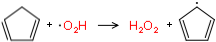

Reaction(reactants=[Species(label="C5H10O(143)", molecule=[Molecule(SMILES="CCCCC=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C5H9O(171)", molecule=[Molecule(SMILES="CCCC[C]=O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.00142415,'cm^3/(mol*s)'), n=4.5134, Ea=(18.0511,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.47877, dn = +|- 0.0513431, dEa = +|- 0.282439 kJ/mol"""))


Reaction(reactants=[Species(label="C6H12O(172)", molecule=[Molecule(SMILES="CCCCCC=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C6H11O(173)", molecule=[Molecule(SMILES="C[CH]CCCC=O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.00019002,'cm^3/(mol*s)'), n=4.26476, Ea=(46.4659,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.20984, dn = +|- 0.0249995, dEa = +|- 0.137522 kJ/mol"""))


Reaction(reactants=[Species(label="C2H2O3(174)", molecule=[Molecule(SMILES="O=COC=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C2HO3(175)", molecule=[Molecule(SMILES="O=[C]OC=O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.000488607,'cm^3/(mol*s)'), n=4.60737, Ea=(49.748,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.39381, dn = +|- 0.0435772, dEa = +|- 0.239718 kJ/mol"""))


Reaction(reactants=[Species(label="C2H4(176)", molecule=[Molecule(SMILES="C=C")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C2H3(177)", molecule=[Molecule(SMILES="[CH]=C")])], kinetics=Arrhenius(A=(0.265705,'cm^3/(mol*s)'), n=3.96021, Ea=(92.4156,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.08257, dn = +|- 0.0104122, dEa = +|- 0.0572774 kJ/mol"""))


Reaction(reactants=[Species(label="C4H10O(178)", molecule=[Molecule(SMILES="CCOCC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C4H9O(179)", molecule=[Molecule(SMILES="C[CH]OCC")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.000282731,'cm^3/(mol*s)'), n=4.50922, Ea=(35.0027,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.37477, dn = +|- 0.0417724, dEa = +|- 0.22979 kJ/mol"""))


Reaction(reactants=[Species(label="C5H10O(180)", molecule=[Molecule(SMILES="CCCC(C)=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C5H9O(181)", molecule=[Molecule(SMILES="[CH2]C(=O)CCC")])], kinetics=Arrhenius(A=(1.01782e-06,'cm^3/(mol*s)'), n=4.93933, Ea=(43.7026,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.65342, dn = +|- 0.0659939, dEa = +|- 0.363032 kJ/mol"""))


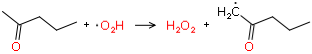

Reaction(reactants=[Species(label="C5H12(182)", molecule=[Molecule(SMILES="CCCCC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C5H11(183)", molecule=[Molecule(SMILES="C[CH]CCC")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.000190466,'cm^3/(mol*s)'), n=4.63624, Ea=(44.7453,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.36159, dn = +|- 0.040508, dEa = +|- 0.222835 kJ/mol"""))


Reaction(reactants=[Species(label="C5H10O(110)", molecule=[Molecule(SMILES="C1CCOCC1")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C5H9O(184)", molecule=[Molecule(SMILES="[CH]1CCCCO1")])], kinetics=Arrhenius(A=(1.25905e-05,'cm^3/(mol*s)'), n=4.94049, Ea=(43.3724,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.65111, dn = +|- 0.0658102, dEa = +|- 0.362022 kJ/mol"""))


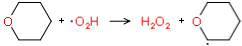

Reaction(reactants=[Species(label="C5H12(124)", molecule=[Molecule(SMILES="CCC(C)C")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C5H11(185)", molecule=[Molecule(SMILES="[CH2]CC(C)C")])], kinetics=Arrhenius(A=(9.21803e-05,'cm^3/(mol*s)'), n=4.5993, Ea=(57.5134,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.36763, dn = +|- 0.0410888, dEa = +|- 0.226029 kJ/mol"""))


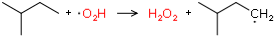

Reaction(reactants=[Species(label="C5H10O(110)", molecule=[Molecule(SMILES="C1CCOCC1")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C5H9O(186)", molecule=[Molecule(SMILES="[CH]1CCCOC1")])], kinetics=Arrhenius(A=(1.84535e-05,'cm^3/(mol*s)'), n=4.81555, Ea=(58.9839,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.57087, dn = +|- 0.0592724, dEa = +|- 0.326057 kJ/mol"""))


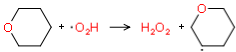

Reaction(reactants=[Species(label="C5H10(104)", molecule=[Molecule(SMILES="C=CCCC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C5H9(187)", molecule=[Molecule(SMILES="C=CC[CH]C")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.000315487,'cm^3/(mol*s)'), n=4.50876, Ea=(47.5193,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.30674, dn = +|- 0.0351114, dEa = +|- 0.193148 kJ/mol"""))


Reaction(reactants=[Species(label="C6H10O(102)", molecule=[Molecule(SMILES="C=C(C)C(=O)CC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C6H9O(188)", molecule=[Molecule(SMILES="C=C(C)C(=O)[CH]C")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(8.14443e-06,'cm^3/(mol*s)'), n=4.81706, Ea=(28.1356,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.54114, dn = +|- 0.0567649, dEa = +|- 0.312264 kJ/mol"""))


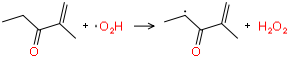

Reaction(reactants=[Species(label="C4H8O(189)", molecule=[Molecule(SMILES="C=C(C)CO")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C4H7O(190)", molecule=[Molecule(SMILES="C=C(C)[CH]O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(8.04843e-06,'cm^3/(mol*s)'), n=4.79274, Ea=(14.1732,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.74322, dn = +|- 0.0729353, dEa = +|- 0.401217 kJ/mol"""))


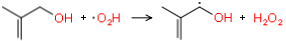

Reaction(reactants=[Species(label="C5H12(182)", molecule=[Molecule(SMILES="CCCCC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C5H11(191)", molecule=[Molecule(SMILES="CC[CH]CC")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.000375325,'cm^3/(mol*s)'), n=4.55086, Ea=(46.0816,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.30718, dn = +|- 0.0351554, dEa = +|- 0.19339 kJ/mol"""))


Reaction(reactants=[Species(label="C3H2O4(192)", molecule=[Molecule(SMILES="O=COC(=O)C=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C3HO4(193)", molecule=[Molecule(SMILES="O=[C]OC(=O)C=O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(1.64583e-06,'cm^3/(mol*s)'), n=5.84699, Ea=(55.5868,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.55717, dn = +|- 0.0581227, dEa = +|- 0.319733 kJ/mol"""))


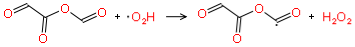

Reaction(reactants=[Species(label="C5H12(124)", molecule=[Molecule(SMILES="CCC(C)C")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C5H11(194)", molecule=[Molecule(SMILES="[CH2]C(C)CC")])], kinetics=Arrhenius(A=(0.000678368,'cm^3/(mol*s)'), n=4.47401, Ea=(58.974,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.27439, dn = +|- 0.0318216, dEa = +|- 0.175051 kJ/mol"""))


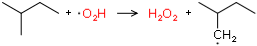

Reaction(reactants=[Species(label="C5H8O(195)", molecule=[Molecule(SMILES="CC=CCC=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C5H7O(196)", molecule=[Molecule(SMILES="CC=CC[C]=O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(4.6226e-05,'cm^3/(mol*s)'), n=4.86568, Ea=(22.7711,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.78423, dn = +|- 0.0759867, dEa = +|- 0.418003 kJ/mol"""))


Reaction(reactants=[Species(label="C6H14(197)", molecule=[Molecule(SMILES="CCCCCC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C6H13(198)", molecule=[Molecule(SMILES="C[CH]CCCC")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.000468774,'cm^3/(mol*s)'), n=4.53367, Ea=(47.5335,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.35032, dn = +|- 0.039417, dEa = +|- 0.216833 kJ/mol"""))


Reaction(reactants=[Species(label="C5H12(124)", molecule=[Molecule(SMILES="CCC(C)C")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C5H11(199)", molecule=[Molecule(SMILES="C[CH]C(C)C")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.0024808,'cm^3/(mol*s)'), n=4.37053, Ea=(46.7402,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.24471, dn = +|- 0.0287286, dEa = +|- 0.158036 kJ/mol"""))


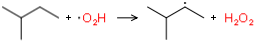

Reaction(reactants=[Species(label="C2H4O(31)", molecule=[Molecule(SMILES="CC=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C2H3O(200)", molecule=[Molecule(SMILES="[CH2]C=O")])], kinetics=Arrhenius(A=(1.13215e-07,'cm^3/(mol*s)'), n=5.33323, Ea=(45.1551,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.08967, dn = +|- 0.0967257, dEa = +|- 0.532088 kJ/mol"""))


Reaction(reactants=[Species(label="C3H4O3(108)", molecule=[Molecule(SMILES="O=CCOC=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C3H3O3(201)", molecule=[Molecule(SMILES="O=[C]OCC=O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.000507,'cm^3/(mol*s)'), n=4.593, Ea=(53.7226,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.36444, dn = +|- 0.040782, dEa = +|- 0.224342 kJ/mol"""))


Reaction(reactants=[Species(label="C5H10(104)", molecule=[Molecule(SMILES="C=CCCC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C5H9(202)", molecule=[Molecule(SMILES="[CH2]CCC=C")])], kinetics=Arrhenius(A=(0.000863445,'cm^3/(mol*s)'), n=4.46539, Ea=(58.4953,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.25872, dn = +|- 0.0301979, dEa = +|- 0.166119 kJ/mol"""))


Reaction(reactants=[Species(label="C4H10O(178)", molecule=[Molecule(SMILES="CCOCC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C4H9O(203)", molecule=[Molecule(SMILES="[CH2]COCC")])], kinetics=Arrhenius(A=(2.65424e-06,'cm^3/(mol*s)'), n=5.31449, Ea=(71.5509,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.89613, dn = +|- 0.0839702, dEa = +|- 0.46192 kJ/mol"""))


Reaction(reactants=[Species(label="C3H6O3(204)", molecule=[Molecule(SMILES="COCOC=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C3H5O3(205)", molecule=[Molecule(SMILES="[CH2]OCOC=O")])], kinetics=Arrhenius(A=(0.0194118,'cm^3/(mol*s)'), n=3.83268, Ea=(38.5247,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.06373, dn = +|- 0.00810811, dEa = +|- 0.0446027 kJ/mol"""))


Reaction(reactants=[Species(label="C3H8O(126)", molecule=[Molecule(SMILES="CCCO")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C3H7O(206)", molecule=[Molecule(SMILES="C[CH]CO")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.0139973,'cm^3/(mol*s)'), n=3.94442, Ea=(47.9109,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.09009, dn = +|- 0.0113214, dEa = +|- 0.0622791 kJ/mol"""))


Reaction(reactants=[Species(label="C5H8O(207)", molecule=[Molecule(SMILES="C=C(C=O)CC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C5H7O(208)", molecule=[Molecule(SMILES="C=C([C]=O)CC")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(5.47687e-05,'cm^3/(mol*s)'), n=4.92848, Ea=(29.9282,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.79755, dn = +|- 0.0769631, dEa = +|- 0.423374 kJ/mol"""))


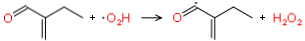

Reaction(reactants=[Species(label="C5H8O(195)", molecule=[Molecule(SMILES="CC=CCC=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C5H7O(209)", molecule=[Molecule(SMILES="[CH2]C=CCC=O")])], kinetics=Arrhenius(A=(9.87226e-09,'cm^3/(mol*s)'), n=5.75392, Ea=(27.3486,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.79556, dn = +|- 0.13492, dEa = +|- 0.742194 kJ/mol"""))


Reaction(reactants=[Species(label="C6H14(197)", molecule=[Molecule(SMILES="CCCCCC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C6H13(210)", molecule=[Molecule(SMILES="CC[CH]CCC")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.00015669,'cm^3/(mol*s)'), n=4.4528, Ea=(46.7795,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.29246, dn = +|- 0.0336692, dEa = +|- 0.185214 kJ/mol"""))


Reaction(reactants=[Species(label="C5H10O(211)", molecule=[Molecule(SMILES="CC(=O)C(C)C")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C5H9O(212)", molecule=[Molecule(SMILES="[CH2]C(=O)C(C)C")])], kinetics=Arrhenius(A=(8.08521e-08,'cm^3/(mol*s)'), n=5.84966, Ea=(39.8384,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.55771, dn = +|- 0.0581684, dEa = +|- 0.319985 kJ/mol"""))


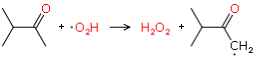

Reaction(reactants=[Species(label="C6H8(213)", molecule=[Molecule(SMILES="C1C=CCCC=1")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C6H7(59)", molecule=[Molecule(SMILES="[CH]1C=CC=CC1")])], kinetics=Arrhenius(A=(5.60285e-06,'cm^3/(mol*s)'), n=5.03863, Ea=(17.4408,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.97032, dn = +|- 0.0890069, dEa = +|- 0.489627 kJ/mol"""))


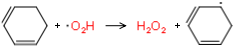

Reaction(reactants=[Species(label="C3H4(214)", molecule=[Molecule(SMILES="C#CC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C3H3(215)", molecule=[Molecule(SMILES="C#C[CH2]")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(9.02065e-08,'cm^3/(mol*s)'), n=5.56952, Ea=(34.8886,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.33181, dn = +|- 0.111115, dEa = +|- 0.611241 kJ/mol"""))


Reaction(reactants=[Species(label="C5H8O(216)", molecule=[Molecule(SMILES="C=C(C)C(C)=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C5H7O(217)", molecule=[Molecule(SMILES="[CH2]C(=O)C(=C)C")])], kinetics=Arrhenius(A=(3.70994e-08,'cm^3/(mol*s)'), n=5.48408, Ea=(47.9008,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.19788, dn = +|- 0.103351, dEa = +|- 0.568535 kJ/mol"""))


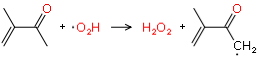

Reaction(reactants=[Species(label="C4H6O(38)", molecule=[Molecule(SMILES="C=C(C)C=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C4H5O(218)", molecule=[Molecule(SMILES="[CH2]C(=C)C=O")])], kinetics=Arrhenius(A=(2.08079e-08,'cm^3/(mol*s)'), n=5.53033, Ea=(29.3721,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.27191, dn = +|- 0.107699, dEa = +|- 0.592453 kJ/mol"""))


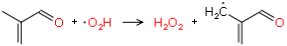

Reaction(reactants=[Species(label="C7H12(219)", molecule=[Molecule(SMILES="C=CCCC=CC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C7H11(220)", molecule=[Molecule(SMILES="[CH2]C=CCCC=C")])], kinetics=Arrhenius(A=(7.96589e-09,'cm^3/(mol*s)'), n=5.61724, Ea=(24.0478,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.57726, dn = +|- 0.12425, dEa = +|- 0.683497 kJ/mol"""))


Reaction(reactants=[Species(label="C5H10O(211)", molecule=[Molecule(SMILES="CC(=O)C(C)C")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C5H9O(221)", molecule=[Molecule(SMILES="C[C](C)C(C)=O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(2.17611e-09,'cm^3/(mol*s)'), n=6.37963, Ea=(17.6927,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.23777, dn = +|- 0.105712, dEa = +|- 0.581523 kJ/mol"""))


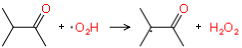

Reaction(reactants=[Species(label="C5H10O(143)", molecule=[Molecule(SMILES="CCCCC=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C5H9O(222)", molecule=[Molecule(SMILES="[CH2]CCCC=O")])], kinetics=Arrhenius(A=(0.000451636,'cm^3/(mol*s)'), n=4.31888, Ea=(58.1426,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.20659, dn = +|- 0.0246474, dEa = +|- 0.135585 kJ/mol"""))


Reaction(reactants=[Species(label="C3H6O3(204)", molecule=[Molecule(SMILES="COCOC=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C3H5O3(223)", molecule=[Molecule(SMILES="COCO[C]=O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.00484826,'cm^3/(mol*s)'), n=4.11104, Ea=(51.3067,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.06146, dn = +|- 0.00782834, dEa = +|- 0.0430637 kJ/mol"""))


Reaction(reactants=[Species(label="C3H8O2(224)", molecule=[Molecule(SMILES="COCOC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C3H7O2(225)", molecule=[Molecule(SMILES="CO[CH]OC")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.000405537,'cm^3/(mol*s)'), n=4.37835, Ea=(23.7318,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.28241, dn = +|- 0.0326449, dEa = +|- 0.17958 kJ/mol"""))


Reaction(reactants=[Species(label="C4H6O2(118)", molecule=[Molecule(SMILES="C=CC(=O)OC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C4H5O2(226)", molecule=[Molecule(SMILES="[CH2]OC(=O)C=C")])], kinetics=Arrhenius(A=(0.000408181,'cm^3/(mol*s)'), n=4.20427, Ea=(48.1227,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.16662, dn = +|- 0.0202255, dEa = +|- 0.111261 kJ/mol"""))


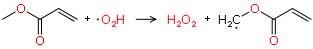

Reaction(reactants=[Species(label="C5H8O(116)", molecule=[Molecule(SMILES="C=CC(=O)CC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C5H7O(227)", molecule=[Molecule(SMILES="C=CC(=O)[CH]C")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(1.55467e-07,'cm^3/(mol*s)'), n=5.27471, Ea=(26.5385,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.01526, dn = +|- 0.0919671, dEa = +|- 0.505911 kJ/mol"""))


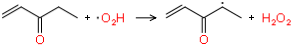

Reaction(reactants=[Species(label="C6H12O(172)", molecule=[Molecule(SMILES="CCCCCC=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C6H11O(228)", molecule=[Molecule(SMILES="CCCC[CH]C=O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(2.56887e-10,'cm^3/(mol*s)'), n=5.8952, Ea=(27.996,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.99859, dn = +|- 0.144121, dEa = +|- 0.792811 kJ/mol"""))


Reaction(reactants=[Species(label="CH4O2(229)", molecule=[Molecule(SMILES="COO")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="CH3O2(230)", molecule=[Molecule(SMILES="CO[O]")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(2.25347e-05,'cm^3/(mol*s)'), n=4.61955, Ea=(0.462874,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.41572, dn = +|- 0.045624, dEa = +|- 0.250978 kJ/mol"""))


Reaction(reactants=[Species(label="C3H6O(83)", molecule=[Molecule(SMILES="CCC=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C3H5O(231)", molecule=[Molecule(SMILES="C[CH]C=O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(1.5612e-08,'cm^3/(mol*s)'), n=5.63323, Ea=(25.7729,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.52069, dn = +|- 0.121336, dEa = +|- 0.667472 kJ/mol"""))


Reaction(reactants=[Species(label="C3H6O2(232)", molecule=[Molecule(SMILES="CCOC=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C3H5O2(233)", molecule=[Molecule(SMILES="C[CH]OC=O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(5.61147e-07,'cm^3/(mol*s)'), n=5.39794, Ea=(53.3084,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.06096, dn = +|- 0.09491, dEa = +|- 0.5221 kJ/mol"""))


Reaction(reactants=[Species(label="C6H10O(106)", molecule=[Molecule(SMILES="C=CC(=O)C(C)C")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C6H9O(234)", molecule=[Molecule(SMILES="C=CC(=O)[C](C)C")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(5.93324e-08,'cm^3/(mol*s)'), n=5.57703, Ea=(24.3886,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.57598, dn = +|- 0.124184, dEa = +|- 0.683136 kJ/mol"""))


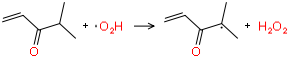

Reaction(reactants=[Species(label="C6H12O(172)", molecule=[Molecule(SMILES="CCCCCC=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C6H11O(235)", molecule=[Molecule(SMILES="CCCCC[C]=O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(2.38992e-05,'cm^3/(mol*s)'), n=4.59948, Ea=(17.9284,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.55725, dn = +|- 0.0581294, dEa = +|- 0.31977 kJ/mol"""))


Reaction(reactants=[Species(label="C5H8O2(236)", molecule=[Molecule(SMILES="C=CCC(=O)OC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C5H7O2(237)", molecule=[Molecule(SMILES="C=C[CH]C(=O)OC")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(5.29618e-10,'cm^3/(mol*s)'), n=5.83949, Ea=(12.045,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.76227, dn = +|- 0.133348, dEa = +|- 0.733546 kJ/mol"""))


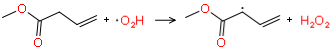

Reaction(reactants=[Species(label="C2H4O(238)", molecule=[Molecule(SMILES="C=CO")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C2H3O(239)", molecule=[Molecule(SMILES="C=[C]O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.131477,'cm^3/(mol*s)'), n=3.83204, Ea=(82.1128,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.05819, dn = +|- 0.00742338, dEa = +|- 0.040836 kJ/mol"""))


Reaction(reactants=[Species(label="C3H4O2(240)", molecule=[Molecule(SMILES="CC(=O)C=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C3H3O2(241)", molecule=[Molecule(SMILES="CC(=O)[C]=O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(9.03096e-05,'cm^3/(mol*s)'), n=4.7819, Ea=(1.76206,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.52563, dn = +|- 0.0554372, dEa = +|- 0.30496 kJ/mol"""))


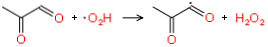

Reaction(reactants=[Species(label="C6H14(197)", molecule=[Molecule(SMILES="CCCCCC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C6H13(242)", molecule=[Molecule(SMILES="[CH2]CCCCC")])], kinetics=Arrhenius(A=(0.000218317,'cm^3/(mol*s)'), n=4.46437, Ea=(58.8852,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.28909, dn = +|- 0.033327, dEa = +|- 0.183332 kJ/mol"""))


Reaction(reactants=[Species(label="C7H14(153)", molecule=[Molecule(SMILES="CC1CCCCC1")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C7H13(243)", molecule=[Molecule(SMILES="CC1C[CH]CCC1")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(8.26892e-07,'cm^3/(mol*s)'), n=5.28799, Ea=(63.0482,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.14314, dn = +|- 0.100041, dEa = +|- 0.550328 kJ/mol"""))


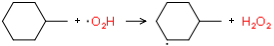

Reaction(reactants=[Species(label="C4H8O(244)", molecule=[Molecule(SMILES="C=COCC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C4H7O(245)", molecule=[Molecule(SMILES="C=CO[CH]C")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(7.57284e-06,'cm^3/(mol*s)'), n=4.76828, Ea=(36.2339,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.50424, dn = +|- 0.0535844, dEa = +|- 0.294768 kJ/mol"""))


Reaction(reactants=[Species(label="C5H12(182)", molecule=[Molecule(SMILES="CCCCC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C5H11(246)", molecule=[Molecule(SMILES="[CH2]CCCC")])], kinetics=Arrhenius(A=(0.000307602,'cm^3/(mol*s)'), n=4.59424, Ea=(57.841,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.32304, dn = +|- 0.0367389, dEa = +|- 0.202101 kJ/mol"""))


Reaction(reactants=[Species(label="C7H12(247)", molecule=[Molecule(SMILES="CC1=CCCCC1")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C7H11(248)", molecule=[Molecule(SMILES="[CH2]C1=CCCCC1")])], kinetics=Arrhenius(A=(3.16788e-07,'cm^3/(mol*s)'), n=5.27195, Ea=(24.6276,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.09691, dn = +|- 0.0971796, dEa = +|- 0.534585 kJ/mol"""))


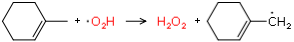

Reaction(reactants=[Species(label="C5H8O(249)", molecule=[Molecule(SMILES="C1=CCOCC1")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C5H7O(250)", molecule=[Molecule(SMILES="[CH]1C=CCOC1")])], kinetics=Arrhenius(A=(2.393e-08,'cm^3/(mol*s)'), n=5.74753, Ea=(28.6265,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.91819, dn = +|- 0.140554, dEa = +|- 0.773191 kJ/mol"""))


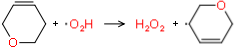

Reaction(reactants=[Species(label="C7H8(251)", molecule=[Molecule(SMILES="CC1C=CC=CC=1")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C7H7(252)", molecule=[Molecule(SMILES="[CH2]C1C=CC=CC=1")])], kinetics=Arrhenius(A=(2.6588e-09,'cm^3/(mol*s)'), n=6.18418, Ea=(28.6153,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.97747, dn = +|- 0.0894823, dEa = +|- 0.492243 kJ/mol"""))


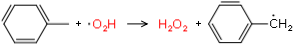

Reaction(reactants=[Species(label="C5H10(149)", molecule=[Molecule(SMILES="CC=CCC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C5H9(253)", molecule=[Molecule(SMILES="[CH2]CC=CC")])], kinetics=Arrhenius(A=(0.000834696,'cm^3/(mol*s)'), n=4.27525, Ea=(57.49,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.18499, dn = +|- 0.0222764, dEa = +|- 0.122542 kJ/mol"""))


Reaction(reactants=[Species(label="C4H6O(79)", molecule=[Molecule(SMILES="CC=CC=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C4H5O(254)", molecule=[Molecule(SMILES="[CH2]C=CC=O")])], kinetics=Arrhenius(A=(2.07977e-10,'cm^3/(mol*s)'), n=6.18894, Ea=(24.1903,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 3.55647, dn = +|- 0.166515, dEa = +|- 0.915997 kJ/mol"""))


Reaction(reactants=[Species(label="C6H12O(172)", molecule=[Molecule(SMILES="CCCCCC=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C6H11O(255)", molecule=[Molecule(SMILES="CC[CH]CCC=O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(9.95109e-05,'cm^3/(mol*s)'), n=4.49369, Ea=(51.038,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.33762, dn = +|- 0.0381765, dEa = +|- 0.210009 kJ/mol"""))


Reaction(reactants=[Species(label="C6H12(122)", molecule=[Molecule(SMILES="C=CCCCC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C6H11(256)", molecule=[Molecule(SMILES="[CH2]CCCC=C")])], kinetics=Arrhenius(A=(0.000430665,'cm^3/(mol*s)'), n=4.42366, Ea=(60.3346,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.27693, dn = +|- 0.032083, dEa = +|- 0.176488 kJ/mol"""))


Reaction(reactants=[Species(label="C5H10O(211)", molecule=[Molecule(SMILES="CC(=O)C(C)C")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C5H9O(257)", molecule=[Molecule(SMILES="[CH2]C(C)C(C)=O")])], kinetics=Arrhenius(A=(0.000228484,'cm^3/(mol*s)'), n=4.88886, Ea=(56.047,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.06954, dn = +|- 0.00882341, dEa = +|- 0.0485376 kJ/mol"""))


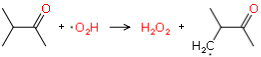

Reaction(reactants=[Species(label="C6H12O(159)", molecule=[Molecule(SMILES="CCCC(=O)CC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C6H11O(258)", molecule=[Molecule(SMILES="[CH2]CC(=O)CCC")])], kinetics=Arrhenius(A=(0.000547843,'cm^3/(mol*s)'), n=4.54687, Ea=(60.3244,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.31524, dn = +|- 0.0359628, dEa = +|- 0.197832 kJ/mol"""))


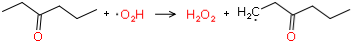

Reaction(reactants=[Species(label="C4H8O(189)", molecule=[Molecule(SMILES="C=C(C)CO")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C4H7O(259)", molecule=[Molecule(SMILES="[CH2]C(=C)CO")])], kinetics=Arrhenius(A=(8.37166e-09,'cm^3/(mol*s)'), n=5.75426, Ea=(31.1394,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.74682, dn = +|- 0.132612, dEa = +|- 0.729496 kJ/mol"""))


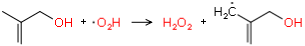

Reaction(reactants=[Species(label="C6H12(122)", molecule=[Molecule(SMILES="C=CCCCC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C6H11(260)", molecule=[Molecule(SMILES="C=C[CH]CCC")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(6.89092e-08,'cm^3/(mol*s)'), n=5.51764, Ea=(22.004,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.53103, dn = +|- 0.121874, dEa = +|- 0.670428 kJ/mol"""))


Reaction(reactants=[Species(label="C6H10O(261)", molecule=[Molecule(SMILES="CC(=O)C=C(C)C")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C6H9O(262)", molecule=[Molecule(SMILES="[CH2]C(=O)C=C(C)C")])], kinetics=Arrhenius(A=(2.8487e-06,'cm^3/(mol*s)'), n=4.92965, Ea=(44.8359,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.63671, dn = +|- 0.0646606, dEa = +|- 0.355698 kJ/mol"""))


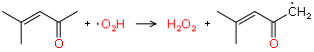

Reaction(reactants=[Species(label="C5H10O(180)", molecule=[Molecule(SMILES="CCCC(C)=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C5H9O(263)", molecule=[Molecule(SMILES="C[CH]CC(C)=O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.000794784,'cm^3/(mol*s)'), n=4.26562, Ea=(43.7449,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.19017, dn = +|- 0.0228487, dEa = +|- 0.125691 kJ/mol"""))


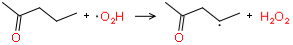

Reaction(reactants=[Species(label="C5H10(149)", molecule=[Molecule(SMILES="CC=CCC")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C5H9(264)", molecule=[Molecule(SMILES="[CH2]C=CCC")])], kinetics=Arrhenius(A=(3.39024e-08,'cm^3/(mol*s)'), n=5.5877, Ea=(23.9257,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.51546, dn = +|- 0.121064, dEa = +|- 0.665975 kJ/mol"""))


Reaction(reactants=[Species(label="C5H8O(136)", molecule=[Molecule(SMILES="C=CCCC=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C5H7O(265)", molecule=[Molecule(SMILES="C=C[CH]CC=O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(9.00839e-09,'cm^3/(mol*s)'), n=5.77243, Ea=(22.7581,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.87101, dn = +|- 0.138415, dEa = +|- 0.761423 kJ/mol"""))


Reaction(reactants=[Species(label="C3H2O4(192)", molecule=[Molecule(SMILES="O=COC(=O)C=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C3HO4(266)", molecule=[Molecule(SMILES="O=[C]C(=O)OC=O")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(1.08431e-09,'cm^3/(mol*s)'), n=6.34606, Ea=(22.493,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 2.07454, dn = +|- 0.0957718, dEa = +|- 0.526841 kJ/mol"""))


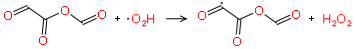

Reaction(reactants=[Species(label="C7H14(153)", molecule=[Molecule(SMILES="CC1CCCCC1")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="C7H13(267)", molecule=[Molecule(SMILES="C[C]1CCCCC1")]), Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")])], kinetics=Arrhenius(A=(0.000756205,'cm^3/(mol*s)'), n=4.41946, Ea=(43.3456,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.34256, dn = +|- 0.0386605, dEa = +|- 0.212672 kJ/mol"""))


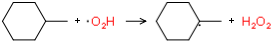

Reaction(reactants=[Species(label="C5H10O(180)", molecule=[Molecule(SMILES="CCCC(C)=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C5H9O(268)", molecule=[Molecule(SMILES="[CH2]CCC(C)=O")])], kinetics=Arrhenius(A=(0.00162435,'cm^3/(mol*s)'), n=4.22072, Ea=(52.4572,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.15855, dn = +|- 0.0193142, dEa = +|- 0.106247 kJ/mol"""))


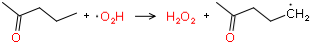

Reaction(reactants=[Species(label="C6H12(269)", molecule=[Molecule(SMILES="C1CCCCC1")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C6H11(270)", molecule=[Molecule(SMILES="[CH]1CCCCC1")])], kinetics=Arrhenius(A=(3.91043e-06,'cm^3/(mol*s)'), n=5.21824, Ea=(61.0254,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.96367, dn = +|- 0.0885635, dEa = +|- 0.487188 kJ/mol"""))


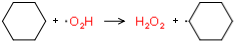

Reaction(reactants=[Species(label="C3H6O2(271)", molecule=[Molecule(SMILES="COC(C)=O")]), Species(label="HO2(2)", molecule=[Molecule(SMILES="[O]O")])], products=[Species(label="H2O2(4)", molecule=[Molecule(SMILES="OO")]), Species(label="C3H5O2(272)", molecule=[Molecule(SMILES="[CH2]C(=O)OC")])], kinetics=Arrhenius(A=(8.3672e-09,'cm^3/(mol*s)'), n=6.07812, Ea=(55.5281,'kJ/mol'), T0=(1,'K'), Tmin=(303.03,'K'), Tmax=(2500,'K'), comment="""Fitted to 59 data points; dA = *|/ 1.78093, dn = +|- 0.0757438, dEa = +|- 0.416667 kJ/mol"""))


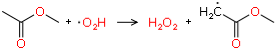

In [11]:
%run -i filtered_kinetics.py

In [12]:
savePyKineticsLibrary(kineticsLibrary)